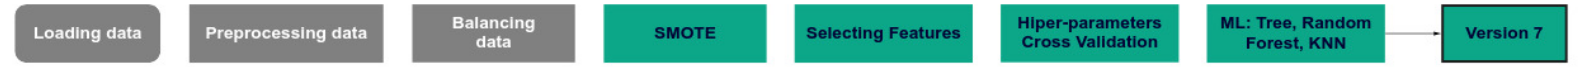

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree     import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics         import accuracy_score, classification_report, confusion_matrix, recall_score
from yellowbrick.classifier  import ConfusionMatrix

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

In [2]:
with open("data_balanced_smote.pkl", 'rb') as f:
    x_train, x_test, y_train, y_test = pickle.load(f)

<IPython.core.display.Javascript object>

In [3]:
x_train.shape, y_train.shape

((34992, 23), (34992,))

In [4]:
x_test.shape, y_test.shape

((7500, 23), (7500,))

In [5]:
df = x_train.copy()

In [6]:
df['DEFAULTING PERSON'] = y_train.copy()

In [7]:
df.columns

Index(['LIMIT_BAL', 'GENDER', 'EDUCATION', 'MARITAL STATUS', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEFAULTING PERSON'],
      dtype='object')

# SELECTION FEATURES: SELECTKBEST

In [8]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)
from sklearn.feature_selection import RFE
rfe = RFE(model, 10)
fit = rfe.fit(x_train, y_train)

/home/eduardo/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [9]:
cols = fit.get_support(indices=True)
df1 = df.iloc[:,cols]
cols = df1.columns

# FILTERING DATA

In [10]:
x_train_fil = x_train[cols]
x_test_fil = x_test[cols]
y_train_fil = y_train.copy()

In [11]:
x_train_fil.head()

,GENDER,EDUCATION,MARITAL STATUS,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,2.0,1.0,2.0,27,0.0,0.0,0.0,0.0,0.0,-1.0
1,2.0,3.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,1.0,38,2.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,1.0,33,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
4,2.0,2.0,1.0,53,2.0,0.0,0.0,0.0,0.0,0.0


In [12]:
x_test_fil.head()

,GENDER,EDUCATION,MARITAL STATUS,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
8225,1,1,2,33,1,2,2,2,2,2
10794,2,2,2,35,0,0,2,0,0,0
9163,2,1,1,44,1,-1,-1,-1,-1,-2
26591,1,2,1,42,0,0,0,0,0,0
6631,1,1,2,29,-2,-2,-2,-2,-2,-2


# MACHINE LEARNING

In [13]:
version7_accuracy = [] # version7 = [tree, random_forest, knn] for accuracy
version7_recall = [] # version7 = [tree, random_forest, knn] for recall

# Decision Tree

In [14]:
parametros = {'criterion':['gini', 'entropy'], 'splitter': ['best', 'random'],
              'max_depth':[2, 4, 6, 8, 10, 12, 15], 'min_samples_split':[2, 4, 6, 8],
              'min_samples_leaf':[1, 3, 5, 7, 9]}

In [15]:
grid = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions= parametros)
grid_result = grid.fit(x_train_fil, y_train_fil)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8467152801520946
{'splitter': 'best', 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 12, 'criterion': 'entropy'}


In [16]:
parametros_tree = grid_result.best_params_

tree = DecisionTreeClassifier(**parametros_tree)
tree.fit(x_train_fil, y_train_fil)
v7_tree = tree.predict(x_test_fil)

In [17]:
version7_accuracy.append( accuracy_score(y_test, v7_tree) )
version7_recall.append( recall_score(y_test, v7_tree, pos_label='1') )

In [18]:
version7_accuracy

[0.8130666666666667]

In [19]:
version7_recall

[0.3939950980392157]

In [20]:
print(classification_report(y_test, v7_tree))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5868
           1       0.61      0.39      0.48      1632

    accuracy                           0.81      7500
   macro avg       0.73      0.66      0.68      7500
weighted avg       0.79      0.81      0.80      7500



In [21]:
cf_tree = confusion_matrix(y_test, v7_tree)

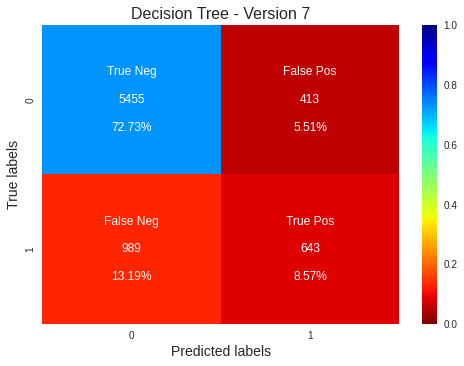

In [22]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{:0.0f}".format(value) for value in cf_tree.flatten()]

group_percentage = ["{0:0.2%}".format(value) for value in cf_tree.flatten()/np.sum(cf_tree)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentage)]

labels = np.asarray(labels).reshape(2,2)

ax = plt.subplot()



sns.heatmap(cf_tree/np.sum(cf_tree), annot=labels, fmt='', cmap = 'jet_r', vmin = 0, vmax = 1, ax = ax)

ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)

plt.title("Decision Tree - Version 7", fontsize = 16)

plt.show()

# Random Forest

In [23]:
parametros = {'n_estimators':[75, 100, 125, 150], 'criterion': ['gini', 'entropy'],
              'max_depth':[2, 4, 6, 8, 10, 15], 'min_samples_split':[2, 4, 6, 8, 10],
             'min_samples_leaf': [1, 3, 5, 7, 9]}

In [24]:
grid = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions= parametros)
grid_result = grid.fit(x_train_fil, y_train_fil)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.8584605950117155
{'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_depth': 10, 'criterion': 'gini'}


In [25]:
parametros_rf = grid_result.best_params_

rf = RandomForestClassifier(**parametros_rf)
rf.fit(x_train_fil, y_train_fil)

v7_rf = rf.predict(x_test_fil)

In [26]:
version7_accuracy.append(accuracy_score(y_test, v7_rf))
version7_recall.append(recall_score(y_test, v7_rf, pos_label='1'))

In [27]:
print(classification_report(y_test, v7_rf))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5868
           1       0.64      0.40      0.49      1632

    accuracy                           0.82      7500
   macro avg       0.74      0.67      0.69      7500
weighted avg       0.80      0.82      0.80      7500



In [28]:
cf_rf = confusion_matrix(y_test, v7_rf)

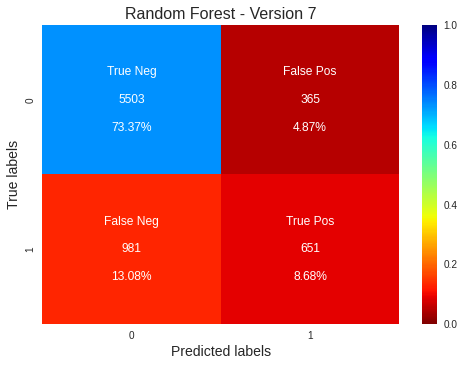

In [29]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{:0.0f}".format(value) for value in cf_rf.flatten()]

group_percentage = ["{0:0.2%}".format(value) for value in cf_rf.flatten()/np.sum(cf_rf)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentage)]

labels = np.asarray(labels).reshape(2,2)

ax = plt.subplot()



sns.heatmap(cf_rf/np.sum(cf_rf), annot=labels, fmt='', cmap = 'jet_r', vmin = 0, vmax = 1, ax = ax)

ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)

plt.title("Random Forest - Version 7", fontsize = 16)

plt.show()

# KNN

In [30]:
parametros = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8, 10, 12], 'weights':['uniform', 'distance'],
             'algorithm':['ball_tree', 'kd_tree', 'brute', 'auto']}

In [31]:
grid = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=parametros)
grid_result = grid.fit(x_train_fil, y_train_fil)
print(grid_result.best_score_)
print(grid_result.best_params_)

0.7572049222236092
{'weights': 'distance', 'n_neighbors': 2, 'algorithm': 'ball_tree'}


In [32]:
parametros_knn = grid_result.best_params_
knn = KNeighborsClassifier(**parametros_knn)
knn.fit(x_train_fil, y_train_fil)
v7_knn = knn.predict(x_test_fil)

In [33]:
version7_accuracy.append(accuracy_score(y_test, v7_knn))
version7_recall.append(recall_score(y_test, v7_knn, pos_label = '1'))

In [34]:
print(classification_report(y_test, v7_knn))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5868
           1       0.40      0.40      0.40      1632

    accuracy                           0.74      7500
   macro avg       0.62      0.62      0.62      7500
weighted avg       0.74      0.74      0.74      7500



In [35]:
cf_knn = confusion_matrix(y_test, v7_knn)

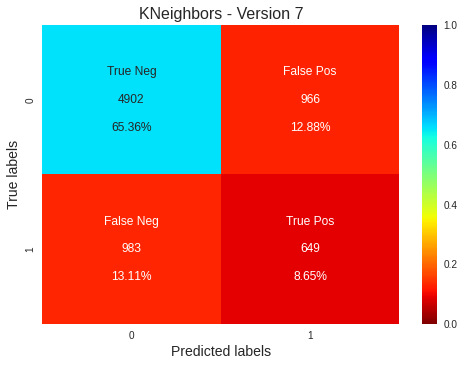

In [36]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{:0.0f}".format(value) for value in cf_knn.flatten()]

group_percentage = ["{0:0.2%}".format(value) for value in cf_knn.flatten()/np.sum(cf_knn)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentage)]

labels = np.asarray(labels).reshape(2,2)

ax = plt.subplot()



sns.heatmap(cf_knn/np.sum(cf_knn), annot=labels, fmt='', cmap = 'jet_r', vmin = 0, vmax = 1, ax = ax)

ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('True labels', fontsize = 14)

plt.title("KNeighbors - Version 7", fontsize = 16)

plt.show()

# Cross Validation

In [37]:
from sklearn.metrics import precision_score, make_scorer

custom_scorer = make_scorer(recall_score, pos_label="1")

#import warnings
#warnings.filterwarnings('ignore')

resultados_tree_accuracy = []
resultados_random_accuracy = []
resultados_knn_accuracy = []

resultados_tree_recall = []
resultados_random_recall = []
resultados_knn_recall = []



for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    tree = DecisionTreeClassifier(**parametros_tree)
    
    scores = cross_val_score(tree, x_train_fil, y_train_fil, scoring=custom_scorer, cv = kfold)
    resultados_tree_recall.append(scores.mean())
    
    scores = cross_val_score(tree, x_train_fil, y_train_fil, scoring='accuracy', cv = kfold)
    resultados_tree_accuracy.append(scores.mean())
    
    print('Tree - Stage: {}'.format(i))
    
    # ==================================================================
        
    rf = RandomForestClassifier(**parametros_rf)
    
    scores = cross_val_score(rf, x_train_fil, y_train_fil,scoring = custom_scorer, cv=kfold)
    resultados_random_recall.append(scores.mean())
    
    scores = cross_val_score(rf, x_train_fil, y_train_fil,scoring = 'accuracy', cv=kfold)
    resultados_random_accuracy.append(scores.mean())
    
    print('Random Forest - Stage: {}'.format(i))
    #===================================================================
    
    knn = KNeighborsClassifier(**parametros_knn)
    
    scores = cross_val_score(knn, x_train_fil, y_train_fil, scoring=custom_scorer, cv=kfold)
    resultados_knn_recall.append(scores.mean())
    
    scores = cross_val_score(knn, x_train_fil, y_train_fil, scoring='accuracy', cv=kfold)
    resultados_knn_accuracy.append(scores.mean())
    
    
    #===================================================================
    print('KNN - Stage: {}'.format(i))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 14


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 15


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 17


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 18


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 18


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 18


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 19


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 19


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 19


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 22


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 22


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 22


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 23


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 23


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 23


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 24


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 24


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 24


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 25


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 26


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 27


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 27


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 27


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tree - Stage: 29


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest - Stage: 29


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNN - Stage: 29


In [38]:
resultados_accuracy = pd.DataFrame({'Decision Tree': resultados_tree_accuracy, 
                           'Random Forest': resultados_random_accuracy,
                          'KNN': resultados_knn_accuracy})

resultados_recall = pd.DataFrame({'Decision Tree': resultados_tree_recall, 
                           'Random Forest': resultados_random_recall,
                          'KNN': resultados_knn_recall})

In [39]:
resultados_accuracy.to_csv("resultados_accuracy_version7.csv")
resultados_recall.to_csv("resultados_recall_version7.csv")

In [40]:
resultados_accuracy.head()

,Decision Tree,Random Forest,KNN
0,0.860825,0.869256,0.761174
1,0.862140,0.869970,0.761831
2,0.861940,0.869770,0.762403
3,0.860511,0.869542,0.764146
4,0.863712,0.869456,0.763575


In [41]:
resultados_recall.head()

,Decision Tree,Random Forest,KNN
0,0.792752,0.805204,0.705324
1,0.796367,0.805753,0.705538
2,0.791882,0.806258,0.706203
3,0.791556,0.805910,0.708444
4,0.795273,0.806152,0.707928


# Saving and Storaging the results

In [42]:
accuracy_list = []
recall_list = []

for i in range(len(resultados_accuracy.columns)):
    accuracy_list.append( resultados_accuracy[ resultados_accuracy.columns[i] ].mean() )
    recall_list.append( resultados_recall[ resultados_recall.columns[i] ].mean() )

In [43]:
resultados_accuracy.mean()

Decision Tree    0.861962
Random Forest    0.869996
KNN              0.762253
dtype: float64

In [44]:
resultados_recall.mean()

Decision Tree    0.793790
Random Forest    0.805862
KNN              0.706129
dtype: float64

In [45]:
accuracy_list

[0.8619617700295323, 0.8699959955905769, 0.7622532609316947]

In [46]:
recall_list

[0.7937899258081765, 0.805862154595005, 0.7061292119909084]

In [47]:
accuracy = pd.read_csv('accuracy_versions.csv')
recall = pd.read_csv("recall_versions.csv")

accuracy

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8
0,Decision Tree,0.733600,0.818782,0.721333,0.627600,0.843486,0.695034,0.697112
1,Random Forest,0.819067,0.817401,0.814667,0.750667,0.874799,0.710658,0.703893
2,KNN,0.762133,0.770861,0.607467,0.578533,0.826992,0.606901,0.679966


In [48]:
recall

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8
0,Decision Tree,0.409314,0.358220,0.411152,0.611520,0.777691,0.561127,0.550735
1,Random Forest,0.368260,0.359337,0.395833,0.619485,0.822276,0.621627,0.570543
2,KNN,0.194240,0.097050,0.530025,0.590686,0.936221,0.658990,0.562789


In [49]:
accuracy['Version 7'] = accuracy_list
recall['Version 7'] = recall_list

In [50]:
accuracy

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8,Version 7
0,Decision Tree,0.733600,0.818782,0.721333,0.627600,0.843486,0.695034,0.697112,0.861962
1,Random Forest,0.819067,0.817401,0.814667,0.750667,0.874799,0.710658,0.703893,0.869996
2,KNN,0.762133,0.770861,0.607467,0.578533,0.826992,0.606901,0.679966,0.762253


In [51]:
recall

,Algorithms,Version 1,Version 2,Version 3,Version 4,Version 5,Version 6,Version 8,Version 7
0,Decision Tree,0.409314,0.358220,0.411152,0.611520,0.777691,0.561127,0.550735,0.793790
1,Random Forest,0.368260,0.359337,0.395833,0.619485,0.822276,0.621627,0.570543,0.805862
2,KNN,0.194240,0.097050,0.530025,0.590686,0.936221,0.658990,0.562789,0.706129


In [52]:
accuracy.to_csv("accuracy_versions.csv", index=None)

recall.to_csv("recall_versions.csv", index = None)